<a href="https://colab.research.google.com/github/ravichas/AMPL-Tutorial/blob/master/03_CHEMBL26_SCN5A_IC50_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Building a Graph Convolutional Network Model for Drug Response Prediction</h1>

The ATOM Modeling PipeLine (AMPL; https://github.com/ATOMconsortium/AMPL) is an open-source, modular, extensible software pipeline for building and sharing models to advance in silico drug discovery.

**Warning: This is an experimental notebook**

AMPL is using Python 3.6.7 while Colab is currently using 3.6.9 listed below so they do not currently match. Your mileage may vary.

## Please change your runtime to GPU 

Go to **Runtime** --> Change **runtime type** to "GPU"


## Goal: Use AMPL for predicting binding affinities -IC50 values- of ligands that could bind to human **Sodium channel protein type 5 subunit alpha** protein using Graph Convolutional Network Model. chEMBL database is the source of the binding affinities (pIC50).

In this notebook, we describe the following steps using AMPL:

1.   Read a ML ready dataset
2.   Fit a Graph Convolutional model
3.   Predict pIC50 values of withheld compounds

## Set up
We first import the AMPL modules for use in this notebook.

The relevant AMPL modules for this example are listed below:

|module|Description|
|-|-|
|`atomsci.ddm.pipeline.model_pipeline`|The model pipeline module is used to fit models and load models for prediction.|
|`atomsci.ddm.pipeline.parameter_parser`|The parameter parser reads through pipeline options for the model pipeline.|
|`atomsci.ddm.utils.curate_data`|The curate data module is used for data loading and pre-processing.|
|`atomsci.ddm.utils.struct_utils`|The structure utilities module is used to process loaded structures.|


import atomsci.ddm.pipeline.compare_models as cmp
import atomsci.ddm.pipeline.model_pipeline as mp
import atomsci.ddm.pipeline.parameter_parser as parse

## Install AMPL 

In [1]:
import requests

# Copy AMPL install script
url='https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/config/install_AMPL_GPU.sh'

downloaded_obj = requests.get(url)
with open("install_AMPL_GPU.sh", "wb") as file:
    file.write(downloaded_obj.content)


# Install AMPL
!chmod u+x install_AMPL_GPU.sh
!time ./install_AMPL_GPU.sh
import sys
if '/content/AMPL/lib/python3.6/site-packages' not in sys.path:
    sys.path.insert(1, '/content/AMPL/lib/python3.6/site-packages')

--2020-10-13 22:05:09--  https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93052469 (89M) [application/x-sh]
Saving to: ‘Miniconda3-latest-Linux-x86_64.sh’

Miniconda3-latest-L 100%[===================>]  88.74M   187MB/s    in 0.5s    

2020-10-13 22:05:09 (187 MB/s) - ‘Miniconda3-latest-Linux-x86_64.sh’ saved [93052469/93052469]

PREFIX=/content/AMPL
Unpacking payload ...
Solving environment: - done

## Package Plan ##

  environment location: /content/AMPL

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - ca-certificates==2020.1.1=0
    - certifi==2020.4.5.1=py38_0
    - cffi==1.14.0=py38he30daa8_1
    - chardet==3.0.4=py38_1003
    - conda-package-handling==1.6.1=py38h7b6447c_0
    - conda==4.8.3=py38_0
    -

In [2]:
!find . -name transformations.py 

./AMPL/lib/python3.6/site-packages/atomsci/ddm/pipeline/transformations.py
./github/AMPL.build/ampl/lib/atomsci/ddm/pipeline/transformations.py
./github/AMPL/atomsci/ddm/pipeline/transformations.py


In [3]:
# There is a problem with the UMAP package, so temporarily remove umap import
%%bash
cat << EOF > ampl.patch
--- transformations.py  2020-09-14 17:08:22.225747322 -0700
+++ transformations_patched.py  2020-09-14 17:08:07.869651225 -0700
@@ -9,7 +9,7 @@

 import numpy as np
 import pandas as pd
-import umap
+# import umap

 import deepchem as dc
 from deepchem.trans.transformers import Transformer, NormalizationTransformer
EOF

patch -N /AMPL/lib/python3.6/site-packages/atomsci/ddm/pipeline/transformations.py

**The following code-chunk will take about 6-7 minutes**

**Note: Can start here if the Colab runtime is restarted. Environment is saved in the Colab runtime file system.**

In [4]:
# Load AMPL in this notebook
import sys

site_packages_path = '/content/AMPL/lib/python3.6/site-packages'
if site_packages_path not in sys.path:
  sys.path.insert(1, site_packages_path)
sys.path

['',
 '/content/AMPL/lib/python3.6/site-packages',
 '/env/python',
 '/usr/lib/python36.zip',
 '/usr/lib/python3.6',
 '/usr/lib/python3.6/lib-dynload',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.6/dist-packages/IPython/extensions',
 '/root/.ipython']

In [5]:
# There is a problem with the previously imported cffi, so delete it and load it with AMPL instead
if 'cffi' in sys.modules:
  del sys.modules['cffi']

In [6]:
import atomsci.ddm.pipeline.compare_models as cmp
import atomsci.ddm.pipeline.model_pipeline as mp
import atomsci.ddm.pipeline.parameter_parser as parse

/content/AMPL/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/content/AMPL/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/content/AMPL/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/content/AMPL/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (

In [7]:
import os
os.mkdir('chembl_activity_models')

**Upload data file ChEMBL26_SCN5A_IC50_human_ml_ready.csv to Colab now.**

In [8]:
import pandas as pd
import requests
import io
url = 'https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/datasets/ChEMBL26_SCN5A_IC50_human_ml_ready.csv'
download = requests.get(url).content
df = pd.read_csv(url, index_col=0)
# Reading the downloaded content and turning it into a pandas dataframe
df = pd.read_csv(io.StringIO(download.decode('utf-8')))
df.iloc[0:5, 0:5]
#df.to_csv('ChEMBL26_SCN5A_IC50_human_ml_ready.csv', index=False)

**Separate out 10% of the data for later prediction**

In [12]:
size_fit = int(len(df) * 0.9)
df_fit = df[:size_fit]
df_pred = df[size_fit:]
df_fit.to_csv('ChEMBL26_SCN5A_IC50_human_ml_ready.csv', index=False)
df_pred.to_csv('ChEMBL26_SCN5A_pred.csv', index=False)

In [13]:
split_config = {
"script_dir": "/content/AMPL/atomsci/ddm",
"dataset_key" : "/content/ChEMBL26_SCN5A_IC50_human_ml_ready.csv",
"datastore": "False",
"split_only": "True",
"splitter": "scaffold",
"split_valid_frac": "0.15",
"split_test_frac": "0.15",
"previously_split": "False",
"prediction_type": "regression",
"response_cols" : "pIC50",
"id_col": "compound_id",
"smiles_col" : "base_rdkit_smiles",
"result_dir": "/content/chembl_activity_models",
"system": "LC",
"transformers": "True",
"model_type": "NN",
"featurizer": "graphconv",
"descriptor_type": "graphconv",
"learning_rate": "0.0007",
"layer_sizes": "64,64,32",
"dropouts" : "0.0,0.0,0.0",
"save_results": "False",
"max_epochs": "100",
"verbose": "True"
}

In [14]:
split_params = parse.wrapper(split_config)

In [15]:
split_model = mp.ModelPipeline(split_params)

In [16]:
split_uuid = split_model.split_dataset()
split_uuid

number of features: 75


2020-10-13 22:15:26,205 Splitting data by scaffold
2020-10-13 22:15:43,226 Dataset split table saved to /content/ChEMBL26_SCN5A_IC50_human_ml_ready_train_valid_test_scaffold_2c701ba6-10e9-48cf-8dac-c85d7dcbae71.csv


'2c701ba6-10e9-48cf-8dac-c85d7dcbae71'

In [17]:
!pip install --upgrade gspread

  Found existing installation: gspread 3.0.1
    Uninstalling gspread-3.0.1:
      Successfully uninstalled gspread-3.0.1


## Train the mode (~ 10 minutes)

In [18]:
train_config = {
"script_dir": "/content/AMPL/atomsci/ddm",
"dataset_key" : "/content/ChEMBL26_SCN5A_IC50_human_ml_ready.csv",
"datastore": "False",
"uncertainty": "False",
"splitter": "scaffold",
"split_valid_frac": "0.15",
"split_test_frac": "0.15",
"previously_split": "True",
"split_uuid": "{}".format(split_uuid),
"prediction_type": "regression",
"response_cols" : "pIC50",
"id_col": "compound_id",
"smiles_col" : "base_rdkit_smiles",
"result_dir": "/content/chembl_activity_models",
"system": "LC",
"transformers": "True",
"model_type": "NN",
"featurizer": "graphconv",
"descriptor_type": "graphconv",
"learning_rate": "0.0007",
"layer_sizes": "64,64,32",
"dropouts" : "0.0,0.0,0.0",
"save_results": "False",
"max_epochs": "100",
"verbose": "True"
}

In [19]:
train_params = parse.wrapper(train_config)

In [20]:
train_model = mp.ModelPipeline(train_params)

## Train_model took ~ 18 minutes on a GPU  (~ 30 minutes on a CPU)

In [21]:
train_model.train_model()

number of features: 75


2020-10-13 22:16:57,105 Previous dataset split restored


n_cnt [1556.]
y_means [5.15798553]
y_stds [0.64819169]
TIMING: dataset construction took 0.978 s
Loading dataset from disk.
TIMING: dataset construction took 0.181 s
Loading dataset from disk.
TIMING: dataset construction took 0.277 s
Loading dataset from disk.


/content/AMPL/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-22


2020-10-13 22:21:30,219 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-22


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-44


2020-10-13 22:21:35,250 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-44


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-66


2020-10-13 22:21:40,290 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-66


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-88


2020-10-13 22:21:45,386 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-88


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-110


2020-10-13 22:21:50,496 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-110


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-132


2020-10-13 22:21:55,575 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-132


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-154


2020-10-13 22:22:00,727 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-154


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-176


2020-10-13 22:22:05,964 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-176


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-198


2020-10-13 22:22:11,237 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-198


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-220


2020-10-13 22:22:16,643 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-220


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-242


2020-10-13 22:22:21,997 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-242


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-264


2020-10-13 22:22:27,205 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-264


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-286


2020-10-13 22:22:32,697 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-286


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-308


2020-10-13 22:22:37,857 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-308


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-330


2020-10-13 22:22:43,230 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-330


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-352


2020-10-13 22:22:48,518 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-352


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-374


2020-10-13 22:22:54,038 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-374


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-396


2020-10-13 22:22:59,458 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-396


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-418


2020-10-13 22:23:05,158 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-418


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-440


2020-10-13 22:23:10,549 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-440


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-462


2020-10-13 22:23:15,873 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-462


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-484


2020-10-13 22:23:21,553 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-484


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-506


2020-10-13 22:23:27,018 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-506


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-528


2020-10-13 22:23:32,551 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-528


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-550


2020-10-13 22:23:38,015 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-550


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-572


2020-10-13 22:23:43,736 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-572


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-594


2020-10-13 22:23:49,220 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-594


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-616


2020-10-13 22:23:54,699 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-616


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-638


2020-10-13 22:24:00,207 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-638


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-660


2020-10-13 22:24:05,734 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-660


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-682


2020-10-13 22:24:11,281 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-682


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-704


2020-10-13 22:24:16,848 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-704


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-726


2020-10-13 22:24:22,473 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-726


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-748


2020-10-13 22:24:28,363 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-748


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-770


2020-10-13 22:24:33,961 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-770


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-792


2020-10-13 22:24:39,533 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-792


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-814


2020-10-13 22:24:45,247 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-814


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-836


2020-10-13 22:24:51,051 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-836


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-858


2020-10-13 22:24:56,868 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-858


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-880


2020-10-13 22:25:02,656 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-880


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-902


2020-10-13 22:25:08,399 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-902


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-924


2020-10-13 22:25:14,208 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-924


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-946


2020-10-13 22:25:20,066 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-946


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-968


2020-10-13 22:25:25,875 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-968


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-990


2020-10-13 22:25:31,457 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-990


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1012


2020-10-13 22:25:38,251 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1012


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1034


2020-10-13 22:25:44,372 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1034


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1056


2020-10-13 22:25:50,523 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1056


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1078


2020-10-13 22:25:56,439 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1078


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1100


2020-10-13 22:26:02,158 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1100


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1122


2020-10-13 22:26:08,155 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1122


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1144


2020-10-13 22:26:14,178 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1144


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1166


2020-10-13 22:26:20,235 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1166


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1188


2020-10-13 22:26:26,104 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1188


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1210


2020-10-13 22:26:32,221 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1210


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1232


2020-10-13 22:26:38,324 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1232


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1254


2020-10-13 22:26:44,471 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1254


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1276


2020-10-13 22:26:50,304 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1276


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1298


2020-10-13 22:26:56,527 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1298


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1320


2020-10-13 22:27:02,758 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1320


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1342


2020-10-13 22:27:08,696 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1342


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1364


2020-10-13 22:27:14,904 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1364


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1386


2020-10-13 22:27:21,171 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1386


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1408


2020-10-13 22:27:27,151 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1408


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1430


2020-10-13 22:27:33,611 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1430


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1452


2020-10-13 22:27:39,681 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1452


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1474


2020-10-13 22:27:45,976 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1474


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1496


2020-10-13 22:27:52,037 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1496


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1518


2020-10-13 22:27:58,540 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1518


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1540


2020-10-13 22:28:04,967 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1540


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1562


2020-10-13 22:28:11,289 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1562


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1584


2020-10-13 22:28:17,749 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1584


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1606


2020-10-13 22:28:23,843 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1606


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1628


2020-10-13 22:28:30,218 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1628


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1650


2020-10-13 22:28:36,673 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1650


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1672


2020-10-13 22:28:42,861 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1672


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1694


2020-10-13 22:28:49,489 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1694


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1716


2020-10-13 22:28:55,740 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1716


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1738


2020-10-13 22:29:02,403 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1738


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1760


2020-10-13 22:29:08,767 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1760


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1782


2020-10-13 22:29:15,386 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1782


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1804


2020-10-13 22:29:21,630 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1804


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1826


2020-10-13 22:29:28,052 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1826


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1848


2020-10-13 22:29:34,822 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1848


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1870


2020-10-13 22:29:41,170 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1870


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1892


2020-10-13 22:29:47,913 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1892


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1914


2020-10-13 22:29:54,355 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1914


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1936


2020-10-13 22:30:00,808 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1936


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1958


2020-10-13 22:30:07,718 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1958


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1980


2020-10-13 22:30:14,257 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-1980


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-2002


2020-10-13 22:30:22,086 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-2002


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-2024


2020-10-13 22:30:28,908 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-2024


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-2046


2020-10-13 22:30:35,467 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-2046


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-2068


2020-10-13 22:30:42,163 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-2068


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-2090


2020-10-13 22:30:49,338 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-2090


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-2112


2020-10-13 22:30:56,215 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-2112


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-2134


2020-10-13 22:31:02,973 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-2134


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-2156


2020-10-13 22:31:10,105 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-2156


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-2178


2020-10-13 22:31:17,395 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-2178


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-462


/content/AMPL/lib/python3.6/site-packages/atomsci/ddm/pipeline/model_wrapper.py:767: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  chkpt_dict = yaml.load(chkpt_in.read())
2020-10-13 22:32:15,016 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model/model-462
2020-10-13 22:32:33,907 Wrote model metadata to file /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model_metadata.json
2020-10-13 22:32:34,116 Wrote model metrics to file /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/model_metrics.json


Wrote model tarball to /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready_model_3876fb3b-acb9-4ac8-8fec-bc1b57948c5c.tar.gz


In [22]:
perf_df = cmp.get_filesystem_perf_results('/content/chembl_activity_models', pred_type='regression')
perf_df

Found data for 1 models under /content/chembl_activity_models


,model_uuid,model_type,dataset_key,featurizer,splitter,model_score_type,feature_transform_type,learning_rate,dropouts,layer_sizes,best_epoch,max_epochs,rf_estimators,rf_max_features,rf_max_depth,model_choice_score,train_r2_score,train_rms_score,train_mae_score,valid_r2_score,valid_rms_score,valid_mae_score,test_r2_score,test_rms_score,test_mae_score
0,3876fb3b-acb9-4ac8-8fec-bc1b57948c5c,NN,/content/ChEMBL26_SCN5A_IC50_human_ml_ready.csv,graphconv,scaffold,r2,normalization,0.0007,"0.00,0.00,0.00","64,64,32",21,100,NaN,NaN,NaN,0.290554,0.714833,0.342949,0.248112,0.290554,0.553697,0.379067,0.283599,0.563706,0.396423


/content/AMPL/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


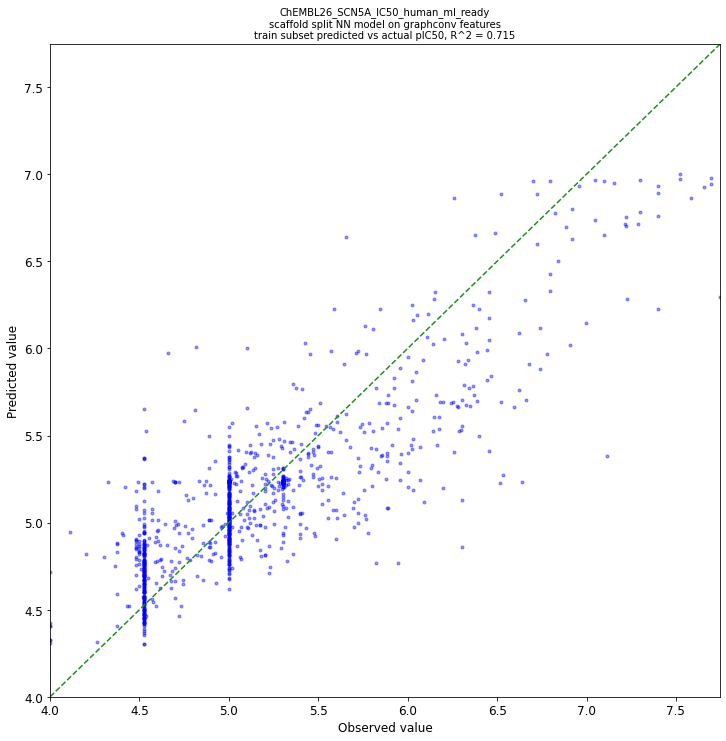

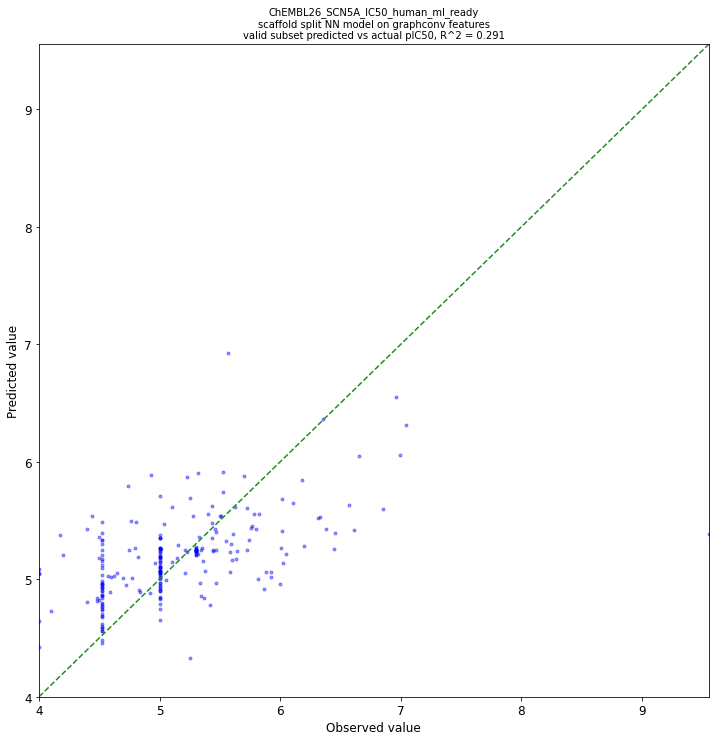

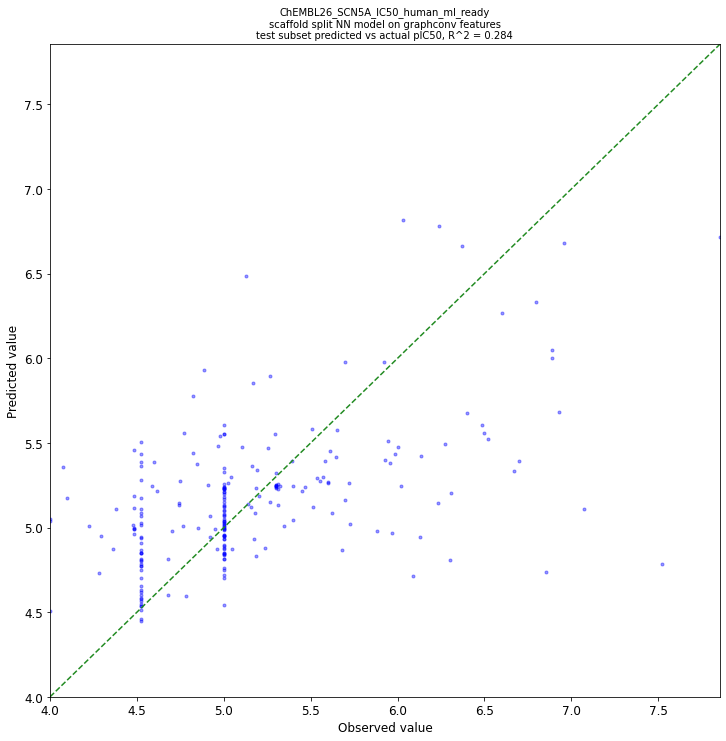

In [24]:
#plot the model fitting
from atomsci.ddm.pipeline import perf_plots as pp
pp.plot_pred_vs_actual(train_model)

In [25]:
#parameters for prediction
pred_params = { 
    "response_cols" : "pIC50",
    "id_col": "compound_id",
    "smiles_col" : "base_rdkit_smiles",
    "result_dir": "/content/chembl_activity_models",
    "transformer_key": ""
}

In [28]:
#predict binding based on pregenerated model
for euid in os.listdir("/content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression"):
  model_dir = "/content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/" + euid
  if "transformers.pkl" in os.listdir(model_dir):
    break

pred_params["result_dir"] = model_dir
pred_params["transformer_key"] = os.path.join(model_dir, "transformers.pkl")

assert(os.path.isfile(pred_params["transformer_key"]))

predparam = parse.wrapper(pred_params)

df_pred = df_pred.rename(columns={predparam.response_cols[0]: 'experimental_values'})

In [30]:
ppp = mp.create_prediction_pipeline_from_file(predparam, model_dir)
predict = ppp.predict_on_dataframe(df_pred)
mergedf = pd.merge(df_pred, predict, on=pred_params["id_col"])
mergedf

Featurization = DynamicFeaturization with graphconv features


/content/AMPL/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/best_model/model-462


2020-10-13 22:44:40,078 Restoring parameters from /content/chembl_activity_models/ChEMBL26_SCN5A_IC50_human_ml_ready/NN_graphconv_scaffold_regression/3876fb3b-acb9-4ac8-8fec-bc1b57948c5c/best_model/model-462


number of features: 75
TIMING: dataset construction took 0.140 s
Loading dataset from disk.


,base_rdkit_smiles_x,compound_id,experimental_values,relation,active,base_rdkit_smiles_y,pred
0,CC[C@H](C)[C@@H]1NC(=O)[C@@H]2CSSC[C@@H]3NC(=O...,CHEMBL3800461,5.165766,NaN,1,CC[C@H](C)[C@@H]1NC(=O)[C@@H]2CSSC[C@@H]3NC(=O...,5.186008
1,Nc1nc(-c2ccc(NC(=O)[C@H]3CCCN3)cc2)c[nH]1,CHEMBL3113259,4.522879,<,0,Nc1nc(-c2ccc(NC(=O)[C@H]3CCCN3)cc2)c[nH]1,4.820891
2,COc1cc(C(F)F)c(C2CC2)cc1-c1nccc2cc(S(=O)(=O)Nc...,CHEMBL3687697,4.522879,<,0,COc1cc(C(F)F)c(C2CC2)cc1-c1nccc2cc(S(=O)(=O)Nc...,4.788332
3,COc1ccccc1-c1c(C#N)cnc2cc(S(=O)(=O)Nc3nccs3)ccc12,CHEMBL3687599,4.522879,<,0,COc1ccccc1-c1c(C#N)cnc2cc(S(=O)(=O)Nc3nccs3)ccc12,4.889140
4,Cc1cc(C#N)cc(N2CCOc3cc(S(=O)(=O)Nc4nccs4)ccc32)c1,CHEMBL3907373,5.632644,NaN,1,Cc1cc(C#N)cc(N2CCOc3cc(S(=O)(=O)Nc4nccs4)ccc32)c1,5.075671
...,...,...,...,...,...,...,...
168,O=C(NCc1ccc(C(F)(F)F)cc1)C1c2ccccc2C(=O)N1CCc1...,CHEMBL2164387,5.795880,NaN,1,O=C(NCc1ccc(C(F)(F)F)cc1)C1c2ccccc2C(=O)N1CCc1...,5.123102
169,COc1ccc(Cl)c(-c2ccc(NC(=O)c3ccnn3C)nc2N)c1,CHEMBL3589904,4.431798,NaN,1,COc1ccc(Cl)c(-c2ccc(NC(=O)c3ccnn3C)nc2N)c1,5.058215
170,N#Cc1cc(F)ccc1N1CCOc2cc(S(=O)(=O)Nc3nccs3)ccc21,CHEMBL3955931,5.000000,<,0,N#Cc1cc(F)ccc1N1CCOc2cc(S(=O)(=O)Nc3nccs3)ccc21,5.250429
171,Clc1cn(Cc2ccccc2)c2ncnc(OC3CCN(Cc4cscn4)CC3)c12,CHEMBL2012181,7.096910,NaN,1,Clc1cn(Cc2ccccc2)c2ncnc(OC3CCN(Cc4cscn4)CC3)c12,6.555266


Text(0.5, 1.0, 'y=1.074x+-0.387\n R^2: 0.441')

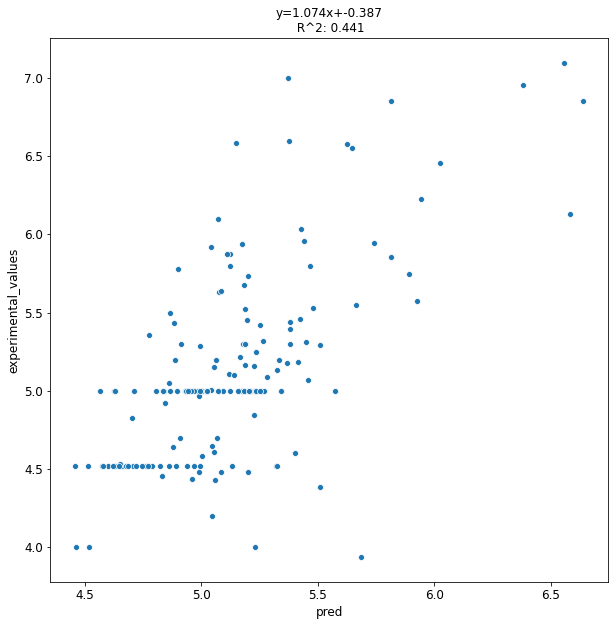

In [38]:
import seaborn as sns
from scipy.stats import linregress
import matplotlib.pyplot as plt

slope, intercept, r_value, p_value, std_err = linregress(mergedf["pred"], mergedf["experimental_values"])

fig, ax = plt.subplots(1,1,figsize=(10,10))
sns.scatterplot(data=mergedf, x="pred", y="experimental_values")
ax.set_title(f"y={slope:.3f}x+{intercept:.3f}\n R^2: {r_value**2:.3f}")